# Gaussian linear regression - multiple case comparison


In [24]:
%pip install --upgrade pip
# freeze blackjax to the last commit as of the time of writing
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip freeze

absl-py==1.4.0
anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
arviz==0.15.1
asttokens==2.2.1
attrs==22.2.0
backcall==0.2.0
beautifulsoup4==4.11.2
black==23.3.0
blackjax @ git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
bleach==6.0.0
cffi==1.15.1
chex==0.1.6
click==8.1.3
cloudpickle==2.2.1
comm==0.1.2
contourpy==1.0.7
cycler==0.11.0
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
diag==0.0.2
dm-tree==0.1.8
executing==1.2.0
fastjsonschema==2.16.3
fastprogress==1.0.3
fonttools==4.39.0
fqdn==1.5.1
gast==0.5.3
h5netcdf==1.1.0
h5py==3.8.0
idna==3.4
ipykernel==6.21.3
ipython==8.11.0
ipython-genutils==0.2.0
ipywidgets==8.0.6
isoduration==20.11.0
jax==0.4.5
jaxlib==0.4.4
jaxopt==0.6
jedi==0.18.2
Jinja2==3.1.2
jsonpointer==2.3
jsonschema==4.17.3
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.6.3
jupyter_client==8.0.3
jupyter_core==5.2.0
jupyter_server==2.4.0
jupyter_server_terminals==0.4.4
jupyterlab-pygments==0.2.

In [26]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as jnp
for i, dev in enumerate(jax.devices()):
  print(f"Device {i}. {dev}")

Device 0. TFRT_CPU_0


In [27]:
import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"
from blackjax.mcmc.hmc import HMCState

In [28]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
import welford as wf
from functools import partial
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import ticker
tfd = tfp.distributions
tfb = tfp.bijectors

In [29]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

sigsq_t = tfb.Exp()

def generate(key: jax.random.KeyArray, N: int, beta0: jax.Array, sigsq0: jax.Array):
    y_key, X_key = jax.random.split(key)
    p = len(beta0)
    X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
    y = X@beta0 + jnp.sqrt(sigsq0)*tfd.Normal(loc=0, scale=1.).sample(sample_shape=(N,), seed=y_key)
    return y, X

def to_constrained(theta: Theta) -> Theta:
    return Theta(beta=theta.beta, sigsq=sigsq_t.forward(theta.sigsq))

def get_model(y, X, K):
    N, p = X.shape
    # use exp to transform sigsq to unconstrained space

    beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=10*jnp.ones(p))
    sigsq_prior = tfd.InverseGamma(2.0, 2.0)

    def logjoint_density(theta: Theta, fold_id: int, model_id: int, prior_only: bool = False) -> jax.Array:
        """Log joint density for a given fold.
        
        Args:
            theta: model parameters
            fold_id: zero-based fold id for training set, -1 for entire dataset
            model_id: 0 for model A, 1 for model B
            prior_only: if True, only return prior density
        
        Returns:
            log density
        """
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
        # prior is same for all folds
        lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
        ll_mask = ((jnp.arange(N) % K) != fold_id).astype(jnp.float32)  # select fold
        # model A has all the predictors, model B is missing the last predictor
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        eps = (y - X @ (theta.beta * beta_mask))
        ll_contribs = tfd.Normal(loc=0., scale=jnp.sqrt(sigsq)).log_prob(eps)
        ll = (ll_mask * ll_contribs).sum() * (not prior_only)
        return lp + ll + sigsq_ldj

    # predictive density log p(y_train|theta)
    def log_pred(theta: Theta, fold_id: int, model_id: int):
        # transform to constrained space
        sigsq = sigsq_t.forward(theta.sigsq)
        pred_mask = ((jnp.arange(N) % K) == fold_id).astype(jnp.float32)
        beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
        ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
        return (pred_mask * ll_contribs).sum()

    # random initialization in the constrained parameter space
    def make_initial_pos(key: jax.random.KeyArray):
        k1, k2 = jax.random.split(key)
        theta = Theta(
            beta=jax.random.normal(key=k1, shape=(p,)),
            sigsq=jax.random.normal(key=k2))
        return theta

    return logjoint_density, log_pred, make_initial_pos


Window adaptation to find a good step size, inverse mass matrix for full-data model

In [30]:
class ExtendedState(NamedTuple):
    """MCMC state--extends regular HMC state variable--also includes batch welford accumulators"""
    state: HMCState  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: wf.LogWelfordState  # accumulator for log predictive
    pred_bws: wf.BatchLogWelfordState  # batch accumulator for log predictive, size b
    pred_bws3: wf.BatchLogWelfordState  # batch accumulator for log predictive, size floor(b/3)
    divergences: jax.Array  # divergence counts (int array)


## Online cross-validation

In [31]:
def inference(
        logjoint_density,
        log_pred,
        make_initial_pos,
        rng_key: jax.random.KeyArray,
        num_integration_steps = 10,
        num_models = 2,
        num_folds = 10,
        total_batches = 50,
        batch_size = 200,
        num_chains = 4
):

    @jax.jit
    def find_initial_params(rng_key, fold_id, model_id):
        """Use adam to approximately maximize the log joint density."""""
        import optax
        params = make_initial_pos(rng_key)
        optimizer = optax.adam(learning_rate=1.0)
        f = lambda x: -logjoint_density(x, fold_id, model_id, prior_only=False)
        state = optimizer.init(params)
        def loop_body(i, carry):
            params, state = carry
            _, grads = jax.value_and_grad(f)(params)
            updates, new_state = optimizer.update(grads, state)
            new_params = optax.apply_updates(params, updates)
            return new_params, new_state
        params, _ = jax.lax.fori_loop(0, 50, loop_body, (params, state))
        return params

    state_k, sampling_k, uncertainty_sim_k, adapt_k = jax.random.split(rng_key, 4)

    # automatic parameter adaptation - just model 0 and full data
    init_pos_1c = find_initial_params(state_k, -1, 0)
    adapt = bj.window_adaptation(
        bj.hmc, lambda x: logjoint_density(x, fold_id=-1, model_id=0),
        num_integration_steps=num_integration_steps, progress_bar=True)
    adapt_res, _ = adapt.run(adapt_k, init_pos_1c, num_steps=2_000)
    print(f"Step size = {adapt_res.parameters['step_size']:.4f}, "
        f"inv mm norm = {jnp.linalg.norm(adapt_res.parameters['inverse_mass_matrix']):.4f}\n")

    def init_ext_state(state, rng_key):
        """Create initial state"""
        return ExtendedState(
            state=state,
            rng_key=rng_key,
            pred_ws=wf.log_welford_init(()),
            pred_bws=wf.batch_log_welford_init((), batch_size),
            pred_bws3=wf.batch_log_welford_init((), batch_size // 3),
            divergences=jnp.array(0, dtype=jnp.int32),
        )

    def init_one_fold(key: jax.random.KeyArray, fold_id: jax.Array, model_id: jax.Array) -> ExtendedState:
        state_k, sampling_k = jax.random.split(key)
        fm_hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
        state_ks = jax.random.split(state_k, num_chains)
        fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, fold_id, model_id)
        fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
        return jax.vmap(init_ext_state)(fm_init_hmcstates, jax.random.split(sampling_k, num_chains))

    @partial(jax.jit, static_argnames=['ndraws'])
    def cv_uncertainty_ci_logscore(state: ExtendedState, simkey: jax.random.KeyArray, d: float=0.05, e: float=0.05, ndraws: int=100):
        # model distribution incorporating CV uncertainty
        # MC (log) variance of contributions to $\hat{p}$
        mf_logbvar = wf.log_welford_var_combine(state.pred_bws.batches, axis=2, ddof=1) + jnp.log(batch_size)
        # MC (log) variance of $\hat{p}$
        mf_logbvar_mean = mf_logbvar - jnp.log(state.pred_ws.n.sum(axis=2))
        # $\log\hat{p}$
        mf_logbmean = logsumexp(wf.log_welford_mean(state.pred_bws.batches), axis=2) - jnp.log(num_chains)
        # $\var S(\hat{p})$ (delta method)
        mf_simvar = jnp.exp(mf_logbvar_mean - 2*mf_logbmean)  # delta method
        etahat_draws = (
            jnp.expand_dims(mf_logbmean, 0)
            + jnp.log(
                jnp.ones_like(mf_simvar) 
                + jnp.sqrt(mf_simvar)
                    * jax.random.truncated_normal(simkey,
                                                -jnp.ones_like(mf_simvar),
                                                jnp.inf,
                                                shape=(ndraws,)+mf_simvar.shape))
        )
        # variability for individual models
        from jax.scipy.stats.norm import ppf as normq
        # sample stats for draw, model (taken over folds), on sum scale
        nfolds = etahat_draws.shape[2]
        dm_mean, dm_var = etahat_draws.sum(axis=2), nfolds*etahat_draws.var(axis=2, ddof=1)
        # upper normal quantile for each draw
        model_std = jnp.sqrt(dm_var.mean(axis=0))
        m_mean = dm_mean.mean(axis=0)
        model_std_low, model_std_high = jnp.quantile(dm_var, q=d/2, axis=0), jnp.quantile(dm_var, q=1-d/2, axis=0)
        dm_uq = normq(1-d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
        dm_lq = normq(d/2, loc=dm_mean, scale=jnp.sqrt(dm_var))
        m_uq, m_lq = dm_uq.mean(axis=0), dm_lq.mean(axis=0)
        m_uq_narrow = normq(1-d/2, loc=m_mean, scale=model_std_low)
        m_lq_narrow = normq(d/2, loc=m_mean, scale=model_std_low)
        m_uq_wide = normq(1-d/2, loc=m_mean, scale=model_std_high)
        m_lq_wide = normq(d/2, loc=m_mean, scale=model_std_high)
        # variability for difference
        ddiff_mean = dm_mean[:,0] - dm_mean[:,1]
        ddiff_var = nfolds*(etahat_draws[:,0,:] - etahat_draws[:,1,:]).var(axis=1, ddof=1)
        diff_std, diff_mean = jnp.sqrt(ddiff_var.mean()), ddiff_mean.mean()
        diff_std_low, diff_std_high = jnp.sqrt(jnp.quantile(ddiff_var, q=jnp.array([e, 1-e])))
        # variance estimate (average over MC variability)
        diff_uq = normq(1-d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var)).mean()
        diff_lq = normq(d/2, loc=ddiff_mean, scale=jnp.sqrt(ddiff_var)).mean()
        # edges of critical regions condition on variance distribution
        diff_uq_wide = normq(1-d/2, loc=diff_mean, scale=diff_std_high)
        diff_lq_wide = normq(d/2, loc=diff_mean, scale=diff_std_high)
        diff_uq_narrow = normq(1-d/2, loc=diff_mean, scale=diff_std_low)
        diff_lq_narrow = normq(d/2, loc=diff_mean, scale=diff_std_low)
        return dict(
            diff_uq=diff_uq,
            diff_lq=diff_lq,
            diff_std=diff_std,
            model_std=model_std,
            m_uq=m_uq,
            m_lq=m_lq,
            m_uq_wide=m_uq_wide,
            m_lq_wide=m_lq_wide,
            m_uq_narrow=m_uq_narrow,
            m_lq_narrow=m_lq_narrow,
            diff_uq_wide=diff_uq_wide,
            diff_lq_wide=diff_lq_wide,
            diff_uq_narrow=diff_uq_narrow,
            diff_lq_narrow=diff_lq_narrow
        )

    @jax.jit
    def inference_stats(state):
        # inference statistics
        ndraws = state.pred_ws.n.sum(axis=2)[0,0]
        logmean = logsumexp(wf.log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
        model_means = logmean.sum(axis=1)
        delta = model_means[0] - model_means[1]
        # monte carlo variance for S_k, per model
        mf_logbvar = wf.log_welford_var_combine(state.pred_bws.batches, axis=2, ddof=1) + jnp.log(batch_size) - jnp.log(ndraws)
        mf_logbmean = logsumexp(wf.log_welford_mean(state.pred_bws.batches), axis=2) - jnp.log(num_chains)
        m_bvar = jnp.exp(mf_logbvar - 2*mf_logbmean).sum(axis=1)  # delta method, sum over folds
        mf_n = state.pred_ws.n.sum(axis=2)[:,0]  # total draw count per fold
        # mcse at the model level (2-vector) for log score (no /n because that happened pre delta method)
        mcse = jnp.sqrt(m_bvar)
        # raw per-model variance
        mf_logvar = wf.log_welford_var_combine(state.pred_ws, axis=2, ddof=1) - jnp.log(ndraws)
        mf_logmean = logsumexp(wf.log_welford_mean(state.pred_ws), axis=2) - jnp.log(num_chains)
        m_var = jnp.exp(mf_logvar - 2*mf_logmean).sum(axis=1)  # delta method, sum over folds
        # by chain independence, we can just add all the variances
        ess = ndraws * m_bvar.sum() / m_var.sum()
        # combined rhat
        W = jnp.exp(wf.log_welford_var(state.pred_ws, ddof=1) - 2*wf.log_welford_mean(state.pred_ws)).mean(axis=2)
        B = jnp.var(wf.log_welford_mean(state.pred_ws), ddof=1, axis=2)
        rhat_eta = (ndraws/(ndraws-1) * W.sum() + 1/ndraws * B.sum())/W.sum()
        # mcse for difference
        differr = jnp.sqrt(jnp.sum(mcse**2))
        return dict(
            logmean=logmean,
            model_means=model_means,
            delta=delta,
            mcse=mcse,
            ess=ess,
            rhat_eta=rhat_eta,
            differr=differr)

    @jax.jit
    def inference_loop(
            ext_states: ExtendedState,
            fold_id: jax.Array,
            model_id: jax.Array) -> Tuple[ExtendedState, HMCState]:
        hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
        def one_chain_inference_loop(state):  # Single chain inference loop
            def one_mcmc_step(ext_state: ExtendedState, _idx)  -> Tuple[ExtendedState, HMCState]:
                # Single chain, single MCMC step.
                iter_key, carry_key = jax.random.split(ext_state.rng_key)
                chain_state, chain_info = hmc.step(iter_key, ext_state.state)
                elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
                carry_state = ExtendedState(
                    state=chain_state,
                    rng_key=carry_key,
                    pred_ws=wf.log_welford_add(elpd_contrib, ext_state.pred_ws),
                    pred_bws=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                    pred_bws3=wf.batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                    divergences=ext_state.divergences + chain_info.is_divergent,
                )
                return carry_state, None  # don't retain chain trace
            next_state, _ = jax.lax.scan(one_mcmc_step, state, jnp.arange(batch_size))
            return next_state
        # run all chains for this fold in parallel
        return jax.vmap(one_chain_inference_loop)(ext_states)

    # dimensions models x folds x chains x param dimension
    model_ids, fold_ids = jnp.arange(num_models), jnp.arange(num_folds)
    sampling_ks = jax.random.split(sampling_k, num_models)
    def init_model_state(model_id, key):
        fold_keys = jax.random.split(key, num_folds)
        return jax.vmap(init_one_fold, in_axes=(0, 0, None))(fold_keys, fold_ids, model_id)
    init_state = jax.vmap(init_model_state)(model_ids, sampling_ks)
    @jax.jit
    def grand_inference_loop(state: ExtendedState):
        def model_inference_loop(state: ExtendedState, model_id: jax.Array):
            def fold_inference_loop(state: ExtendedState, fold_id: jax.Array):
                return inference_loop(state, fold_id, model_id)
            return jax.vmap(fold_inference_loop)(state, fold_ids)
        return jax.vmap(model_inference_loop)(state, model_ids)
    
    res = defaultdict(list)  # optional O(N) state for making plots, monitoring progress
    state = init_state
    for _ in range(total_batches):
        state = grand_inference_loop(state)
        for key, stat in inference_stats(state).items():
            res[key].append(stat)
        for key, stat in cv_uncertainty_ci_logscore(state, uncertainty_sim_k).items():
            res[key].append(stat)
    assert jnp.all(state.divergences == 0), print(f"WARNING: {state.divergences.sum()} divergences")
    res = {k: jnp.stack(res[k]) for k in res}  # results as arrays
    res.update(dict(num_integration_steps = num_integration_steps,
        num_models = num_models,
        num_folds = num_folds,
        total_batches = total_batches,
        batch_size = batch_size,
        num_chains = num_chains))
    return res

In [32]:
inference_key, data_key = jax.random.split(jax.random.PRNGKey(123))

beta0s = jnp.array([
    [1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.5],
    [1.0, 1.0, 1.0, 0.4]
])

results = []
for i in range(beta0s.shape[0]):
    print(f"**** Model {i} ****")
    K = 10
    y, X = generate(
        key=data_key,
        N = 100,
        beta0 = beta0s[i],
        sigsq0 = jnp.array(2.0))

    ljdens, lpred, makepos = get_model(y, X, K)
    res = inference(
        ljdens,
        lpred,
        makepos,
        rng_key=inference_key,
        num_integration_steps = 10,
        num_models = 2,
        num_folds = K,
        total_batches = 50,
        batch_size = 200
    )
    results.append(res)

**** Model 0 ****
Running window adaptation



Step size = 0.6762, inv mm norm = 0.0534

**** Model 1 ****
Running window adaptation



Step size = 0.6346, inv mm norm = 0.0519

**** Model 2 ****
Running window adaptation



Step size = 0.6442, inv mm norm = 0.0546



Inference procedure

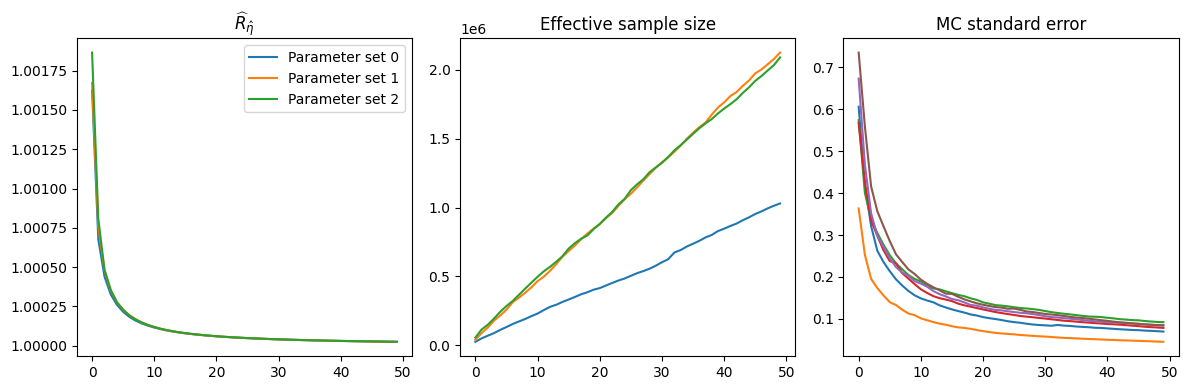

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
prhat, pess, pmcse = axes
for i, res in enumerate(results):
    prhat.plot(res['rhat_eta'], label=f"Parameter set {i}")
    pess.plot(res['ess'])
    pmcse.plot(res['mcse'])

prhat.legend()
prhat.set_title(r"$\widehat{R}_{\hat{\eta}}$")
pess.set_title("Effective sample size")
pmcse.set_title("MC standard error")
fig.tight_layout()

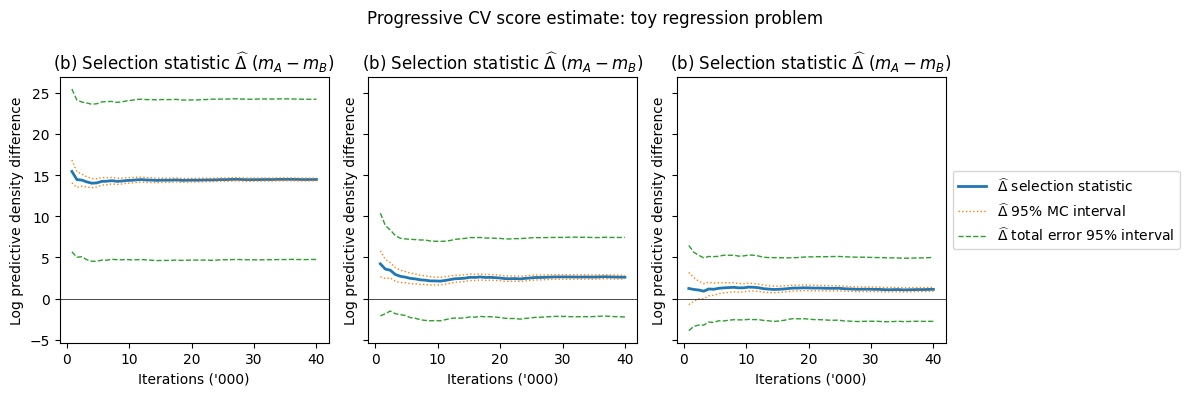

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
it = jnp.arange(1, res['total_batches']+1) * res['batch_size'] * res['num_chains']

zcrit = jax.scipy.stats.norm.ppf(0.975)

for i, (res, ax) in enumerate(zip(results, axes)):
    _m = ax.plot(it, res['delta'], linewidth=2)
    _c = ax.plot(it, res['delta'] + zcrit*res['differr'], linewidth=1, linestyle=':')
    ax.plot(it, res['delta'] - zcrit*res['differr'], linewidth=1, linestyle=':', color=_c[0].get_color())
    _cv = ax.plot(it, res['diff_uq'], linewidth=1, linestyle='--')
    ax.plot(it, res['diff_lq'], linewidth=1, linestyle='--', color=_cv[0].get_color())
    ax.set_title(r'(b) Selection statistic $\widehat{\Delta}$ ($m_A - m_B$)')
    ax.set_ylabel("Log predictive density difference")
    ax.axhline(0, linewidth=0.5, color='k')

ax.legend(
    [_m[0], _c[0], _cv[0]],
    [r'$\widehat{\Delta}$ selection statistic', r'$\widehat{\Delta}$ 95% MC interval', r'$\widehat{\Delta}$ total error 95% interval'],
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))

fmt = ticker.FuncFormatter(lambda x, pos: f'{x/1e3:.0f}')
for ax in axes:
    ax.set_xlabel("Iterations ('000)")
    ax.xaxis.set_major_formatter(fmt)

fig.suptitle(f'Progressive CV score estimate: toy regression problem')
fig.tight_layout()

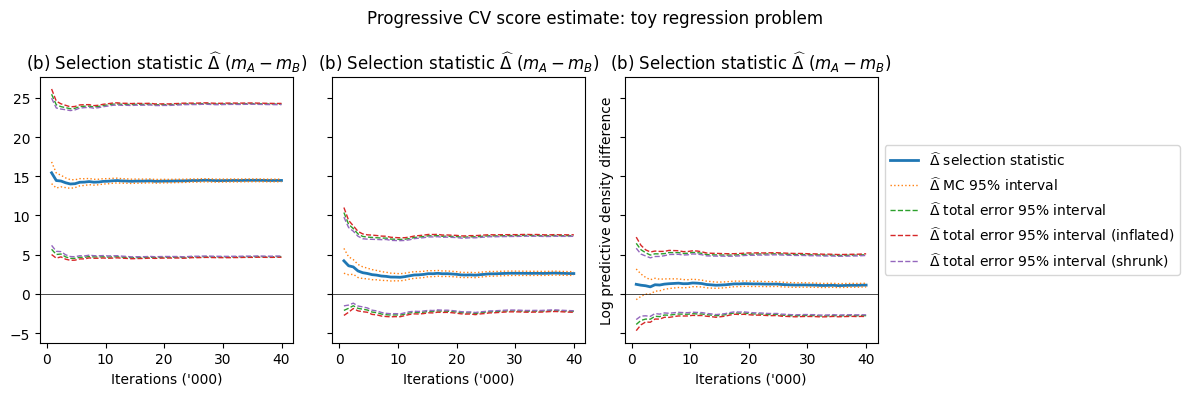

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

zcrit = jax.scipy.stats.norm.ppf(0.975)

for i, (res, ax) in enumerate(zip(results, axes)):
    it = jnp.arange(1, res['total_batches']+1) * res['batch_size'] * res['num_chains']
    _m = ax.plot(it, res['delta'], linewidth=2)
    _c = ax.plot(it, res['delta'] + zcrit*res['differr'], linewidth=1, linestyle=':')
    ax.plot(it, res['delta'] - zcrit*res['differr'], linewidth=1, linestyle=':', color=_c[0].get_color())
    _cv = ax.plot(it, res['diff_uq'], linewidth=1, linestyle='--')
    ax.plot(it, res['diff_lq'], linewidth=1, linestyle='--', color=_cv[0].get_color())
    _cvw = ax.plot(it, res['diff_uq_wide'], linewidth=1, linestyle='--')
    ax.plot(it, res['diff_lq_wide'], linewidth=1, linestyle='--', color=_cvw[0].get_color())
    _cvn = ax.plot(it, res['diff_uq_narrow'], linewidth=1, linestyle='--')
    ax.plot(it, res['diff_lq_narrow'], linewidth=1, linestyle='--', color=_cvn[0].get_color())
    ax.set_title(r'(b) Selection statistic $\widehat{\Delta}$ ($m_A - m_B$)')
    ax.axhline(0, linewidth=0.5, color='k')

fmt = ticker.FuncFormatter(lambda x, pos: f'{x/1e3:.0f}')
for ax in axes:
    ax.set_xlabel("Iterations ('000)")
    ax.xaxis.set_major_formatter(fmt)

ax.legend(
    [_m[0], _c[0], _cv[0], _cvw[0], _cvn[0]],
    [r'$\widehat{\Delta}$ selection statistic', r'$\widehat{\Delta}$ MC 95% interval', r'$\widehat{\Delta}$ total error 95% interval',
    r'$\widehat{\Delta}$ total error 95% interval (inflated)', r'$\widehat{\Delta}$ total error 95% interval (shrunk)'],
    loc='center left',
    bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Log predictive density difference")

fig.suptitle(f'Progressive CV score estimate: toy regression problem')
fig.tight_layout()
fig.savefig('reg_cmp.pdf', bbox_inches=0, transparent=True)